In [8]:
from fast_transformers.builders import TransformerEncoderBuilder
from fast_transformers.masking import LengthMask, TriangularCausalMask
import torch

model = TransformerEncoderBuilder.from_kwargs(
    n_layers=4,
    n_heads=4,
    feed_forward_dimensions=128,
    query_dimensions=32,
    value_dimensions=32,
    attention_type="full" # this means normal softmax attention
).get()

x = torch.rand(
    10,  # batch size 
    100, # sequence length
    128  # feature dimensions
)
y = model(x) # calling without masks which means attend to everything
y = model(
    x,
    attn_mask=TriangularCausalMask(100),   # causal masking
    length_mask=LengthMask(torch.tensor([
        100, 70, 60, 30, 80, 100,          # The sequence length for every
        50, 40, 10, 20                     # sample in the batch
    ]))
)
print("If you reached here, everything works", y.shape)

If you reached here, everything works torch.Size([10, 100, 128])


In [9]:
import math
from fast_transformers.builders import RecurrentEncoderBuilder

class RecurrentGenerator(torch.nn.Module):
    class PositionalEncoding(torch.nn.Module):
        def __init__(self, d_model, dropout=0.0, max_len=5000):
            super(RecurrentGenerator.PositionalEncoding, self).__init__()
            self.dropout = torch.nn.Dropout(p=dropout)
            self.d_model = d_model
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)

        def forward(self, x, i):
            pos_embedding =  self.pe[0, i:i+1]
            x = torch.cat(
                [x, pos_embedding.expand_as(x)],
                dim=1
            )
            return self.dropout(x)

    def __init__(self, d_model, sequence_length, mixtures,
                 attention_type="full", n_layers=4, n_heads=4,
                 d_query=32, dropout=0.1, softmax_temp=None,
                 attention_dropout=0.1):
        super(RecurrentGenerator, self).__init__()

        self.pos_embedding = self.PositionalEncoding(
            d_model//2,
            max_len=sequence_length
        )
        self.value_embedding = torch.nn.Embedding(
            256,
            d_model//2
        )
        self.transformer = RecurrentEncoderBuilder.from_kwargs(
            attention_type=attention_type,
            n_layers=n_layers,
            n_heads=n_heads,
            feed_forward_dimensions=n_heads*d_query*4,
            query_dimensions=d_query,
            value_dimensions=d_query,
            dropout=dropout,
            softmax_temp=softmax_temp,
            attention_dropout=attention_dropout
        ).get()
        self.predictor = torch.nn.Linear(
            d_model,
            mixtures * 3
        )

    def forward(self, x, i=0, memory=None):
        x = x.view(x.shape[0])
        x = self.value_embedding(x)
        x = self.pos_embedding(x, i)
        y_hat, memory = self.transformer(x, memory)
        y_hat = self.predictor(y_hat)

        return y_hat, memory

In [10]:
class Generator(torch.nn.Module):
    class PositionalEncoding(torch.nn.Module):
        def __init__(self, d_model, dropout=0.0, max_len=5000):
            super(Generator.PositionalEncoding, self).__init__()
            self.dropout = torch.nn.Dropout(p=dropout)
            self.d_model = d_model
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)

        def forward(self, x):
            pos_embedding =  self.pe[:, :x.size(1), :]
            pos_embedding = torch.repeat_interleave(pos_embedding, x.shape[0], dim=0)
            x =  torch.cat([x, pos_embedding], dim=2)
            return self.dropout(x)

    def __init__(self, d_model, sequence_length, mixtures,
                 attention_type="full", n_layers=4, n_heads=4,
                 d_query=32, dropout=0.1, softmax_temp=None,
                 attention_dropout=0.1):
        super(Generator, self).__init__()

        self.pos_embedding = self.PositionalEncoding(
            d_model//2,
            max_len=sequence_length
        )
        self.value_embedding = torch.nn.Embedding(
            256,
            d_model//2
        )

        self.transformer = TransformerEncoderBuilder.from_kwargs(
            attention_type=attention_type,
            n_layers=n_layers,
            n_heads=n_heads,
            feed_forward_dimensions=n_heads*d_query*4,
            query_dimensions=d_query,
            value_dimensions=d_query,
            dropout=dropout,
            softmax_temp=softmax_temp,
            attention_dropout=attention_dropout
        ).get()

        hidden_size = n_heads*d_query
        self.predictor = torch.nn.Linear(
            hidden_size,
            mixtures * 3
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.value_embedding(x)
        x = self.pos_embedding(x)
        triangular_mask = TriangularCausalMask(x.shape[1], device=x.device)
        y_hat = self.transformer(x, attn_mask=triangular_mask)
        y_hat = self.predictor(y_hat)

        return y_hat

In [11]:
def sample_mol(y_hat, num_classes=256):
    """Sample from mixture of logistics.

    y_hat: NxC where C is 3*number of logistics
    """
    assert len(y_hat.shape) == 2

    N = y_hat.size(0)
    nr_mix = y_hat.size(1) // 3

    probs = torch.softmax(y_hat[:, :nr_mix], dim=-1)
    means = y_hat[:, nr_mix:2 * nr_mix]
    scales = torch.nn.functional.elu(y_hat[:, 2*nr_mix:3*nr_mix]) + 1.0001

    indices = torch.multinomial(probs, 1).squeeze()
    batch_indices = torch.arange(N, device=probs.device)
    mu = means[batch_indices, indices]
    s = scales[batch_indices, indices]
    u = torch.rand(N, device=probs.device)
    preds = mu + s*(torch.log(u) - torch.log(1-u))

    return torch.min(
        torch.max(
            torch.round((preds+1)/2*(num_classes-1)),
            preds.new_zeros(1),
        ),
        preds.new_ones(1)*(num_classes-1)
    ).long().view(N, 1)


def predict_with_recurrent(model, images, n):
    memory = None
    y_hat = []
    x_hat = []

    with torch.no_grad():
        for i in range(n):
            x_hat.append(images[:, i:i+1])
            yi, memory = model(x_hat[-1], i=i, memory=memory)
            y_hat.append(yi)

        for i in range(n, images.shape[1]):
            x_hat.append(sample_mol(y_hat[-1], 256))
            yi, memory = model(x_hat[-1], i=i, memory=memory)
            y_hat.append(yi)

        x_hat.append(sample_mol(y_hat[-1], 256))
        x_hat = torch.stack(x_hat, dim=1)

    return x_hat


def predict(model, images, n):
    N, L = images.shape
    x_hat = images.new_zeros(N, L+1, dtype=torch.long)
    x_hat[:, :n] = images[:, :n]
    with torch.no_grad():
        for i in range(n, L):
            y_hat = model(x_hat[:, :i])
            x_hat[:, i:i+1] = sample_mol(y_hat[:,-1,:], 256)
        x_hat[:, -1:] = sample_mol(y_hat[:,-1,:], 256)
    return x_hat

In [12]:
import io
import requests

LINEAR_MODEL = "https://drive.google.com/uc?export=download&id=17fc94TzytTdAwNMVCE7qOg75-CWLGi_p"
SOFTMAX_MODEL = "https://drive.google.com/uc?export=download&id=1L47Ode6GxCMQbVMK33_ANjCu2iA4rf8l"

linear_weights = torch.load(io.BytesIO(requests.get(LINEAR_MODEL).content))
softmax_weights = torch.load(io.BytesIO(requests.get(SOFTMAX_MODEL).content))

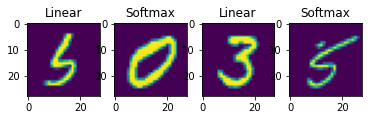

In [52]:
linear = RecurrentGenerator(256, 783, 10, "linear", 8, 8)
linear.load_state_dict(linear_weights)
linear.eval()
full = RecurrentGenerator(256, 783, 10, "full", 8, 8)
full.load_state_dict(softmax_weights)
full.eval()

images_linear = predict_with_recurrent(linear, torch.zeros(2, 783, dtype=torch.int64), 1)
images_full = predict_with_recurrent(full, torch.zeros(2, 783, dtype=torch.int64), 1)

import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4)
ax[0].set_title("Linear")
ax[0].imshow(images_linear[0].cpu().numpy().reshape(28, 28))
ax[1].set_title("Softmax")
ax[1].imshow(images_full[0].cpu().numpy().reshape(28, 28))
ax[2].set_title("Linear")
ax[2].imshow(images_linear[1].cpu().numpy().reshape(28, 28))
ax[3].set_title("Softmax")
ax[3].imshow(images_full[1].cpu().numpy().reshape(28, 28))

In [15]:
import time

start = time.time()
images_linear = predict_with_recurrent(linear, torch.zeros(100, 783, dtype=torch.int64), 1)
end = time.time()
print("Linear took", round(end-start, 2), "s")

start = time.time()
images_full = predict_with_recurrent(full, torch.zeros(100, 783, dtype=torch.int64), 1)
end = time.time()
print("Stateful-softmax took", round(end-start, 2), "s")

Linear took 33.88 s
Stateful-softmax took 156.68 s
